# Meta Models

Certain models in scikit-lego are "meta". Meta models are
models that depend on other estimators that go in and these
models will add features to the input model. One way of thinking
of a meta model is to consider it to be a way to "decorate" a
model.

This part of the documentation will highlight a few of them.

## Thresholder

The thresholder can help tweak recall and precision of a model
by moving the threshold value of `predict_proba`. Commonly this
threshold is set at 0.5 for two classes. This meta-model can
decorate an estimator with two classes such that the threshold
moves.

We demonstrate the working below. First we'll generate a skewed dataset.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from sklearn.pipeline import Pipeline
from sklearn.datasets import make_blobs
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer

from sklego.meta import Thresholder

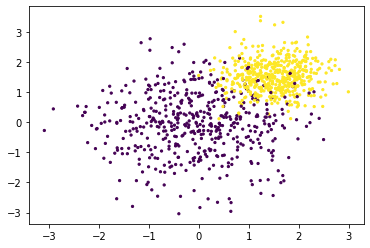

In [2]:
X, y = make_blobs(1000, centers=[(0, 0), (1.5, 1.5)], cluster_std=[1, 0.5])
plt.scatter(X[:, 0], X[:, 1], c=y, s=5);

Next we'll make a cross validation pipeline to try out this thresholder.

In [3]:
pipe = Pipeline([
    ("model", Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.1))
])

mod = GridSearchCV(estimator=pipe,
                   param_grid = {"model__threshold": np.linspace(0.1, 0.9, 50)},
                   scoring={"precision": make_scorer(precision_score),
                            "recall": make_scorer(recall_score),
                            "accuracy": make_scorer(accuracy_score)},
                   refit="precision",
                   cv=5)

mod.fit(X, y);

With this cross validation trained, we'll make a chart to show the
effect of changing the threshold value.

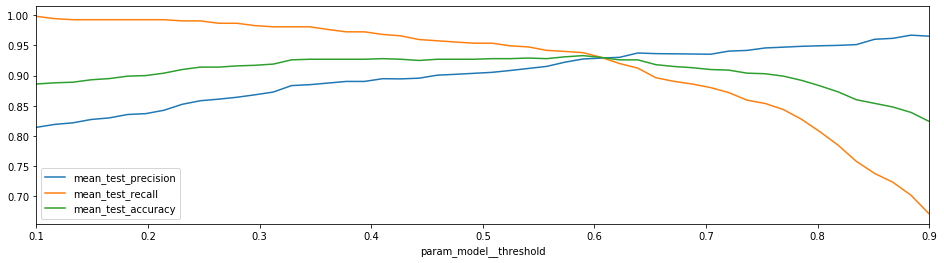

In [4]:
(pd.DataFrame(mod.cv_results_)
 .set_index("param_model__threshold")
 [['mean_test_precision', 'mean_test_recall', 'mean_test_accuracy']]
 .plot(figsize=(16, 4)));

Increasing the threshold will increase the precision but as expected this is at the
cost of recall (and accuracy).

## Grouped Estimation

<img src="_static/grouped-model.png" width="50%">

To help explain what it can do we'll consider three methods to predict
the chicken weight. The chicken data has 578 rows and 4 columns
from an experiment on the effect of diet on early growth of chicks.
The body weights of the chicks were measured at birth and every second
day thereafter until day 20. They were also measured on day 21.
There were four groups on chicks on different protein diets.

### Setup

Let's first load a bunch of things to do this.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklego.datasets import load_chicken
from sklego.preprocessing import ColumnSelector

df = load_chicken(give_pandas=True)

def plot_model(model):
    df = load_chicken(give_pandas=True)
    model.fit(df[['diet', 'time']], df['weight'])
    metric_df = df[['diet', 'time', 'weight']].assign(pred=lambda d: model.predict(d[['diet', 'time']]))
    metric = mean_absolute_error(metric_df['weight'], metric_df['pred'])
    plt.figure(figsize=(12, 4))
    plt.scatter(df['time'], df['weight'])
    for i in [1, 2, 3, 4]:
        pltr = metric_df[['time', 'diet', 'pred']].drop_duplicates().loc[lambda d: d['diet'] == i]
        plt.plot(pltr['time'], pltr['pred'], color='.rbgy'[i])
    plt.title(f"linear model per group, MAE: {np.round(metric, 2)}");

This code will be used to explain the steps below.

### Model 1: Linear Regression with Dummies

First we start with a baseline.

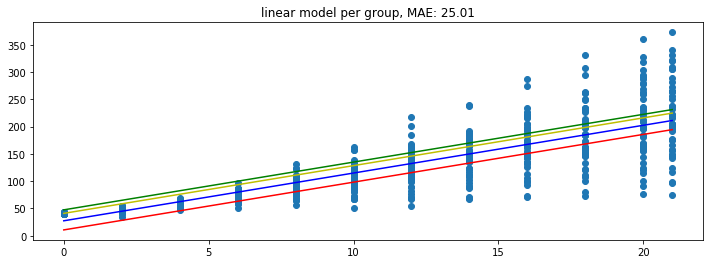

In [6]:
feature_pipeline = Pipeline([
    ("datagrab", FeatureUnion([
         ("discrete", Pipeline([
             ("grab", ColumnSelector("diet")),
             ("encode", OneHotEncoder(categories="auto", sparse=False))
         ])),
         ("continous", Pipeline([
             ("grab", ColumnSelector("time")),
             ("standardize", StandardScaler())
         ]))
    ]))
])

pipe = Pipeline([
    ("transform", feature_pipeline),
    ("model", LinearRegression())
])

plot_model(pipe)

Because the model is linear the dummy variable causes the intercept
to change but leaves the gradient untouched. This might not be what
we want from a model. So let's see how the grouped model can adress
this.

### Model 2: Linear Regression in GroupedEstimation

The goal of the grouped estimator is to allow us to split up our data.
The image below demonstrates what will happen.

<img src="_static/grouped-df.png" width="70%">

We train 5 models in total because the model will also train a
fallback automatically (you can turn this off via `use_fallback=False`).
The idea behind the fallback is that we can predict something if
the group does not appear in the prediction.

Each model will accept features that are in `X` that are not
part of the grouping variables. In this case each group will
model based on the `time` since `weight` is what we're trying
to predict.

Applying this model to the dataframe is easy.

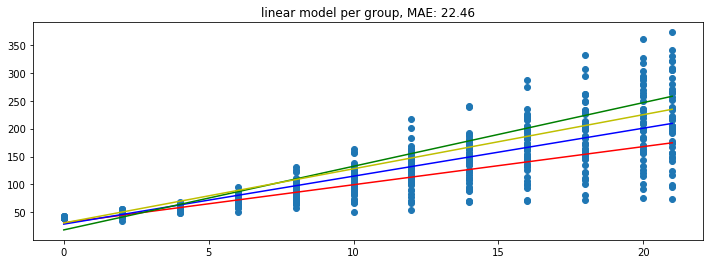

In [7]:
from sklego.meta import GroupedEstimator
mod = GroupedEstimator(LinearRegression(), groups=["diet"])
plot_model(mod)

And the model looks a bit better.

### Model 3: Dummy Regression in GroupedEstimation

We could go a step further and train a [DummyRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) per diet
per timestep. The code below works similar as the previous example
but one difference is that the grouped model does not receive a
dataframe but a numpy array.

<img src="_static/grouped-np.png" width="70%">

Note that we're also grouping over more than one column here.
The code that does this is listed below.

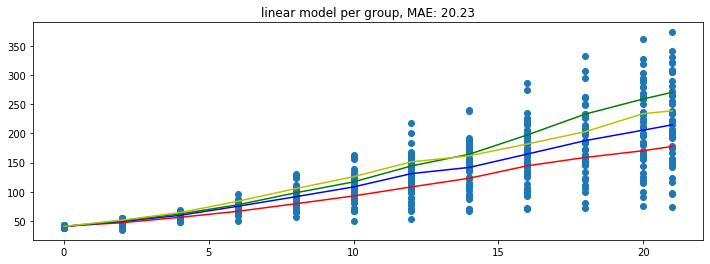

In [8]:
from sklearn.dummy import DummyRegressor

feature_pipeline = Pipeline([
    ("datagrab", FeatureUnion([
         ("discrete", Pipeline([
             ("grab", ColumnSelector("diet")),
         ])),
         ("continous", Pipeline([
             ("grab", ColumnSelector("time")),
         ]))
    ]))
])

pipe = Pipeline([
    ("transform", feature_pipeline),
    ("model", GroupedEstimator(DummyRegressor(strategy="mean"), groups=[0, 1]))
])

plot_model(pipe)

Note that these predictions seems to yield the lowest error but take it
with a grain of salt since these errors are only based on the train set.

## Decayed Estimation

Often you are interested in predicting the future. You use the data from
the past in an attempt to achieve this and it could be said that perhaps
data from the far history is less relevant than data from the recent past.

This is the idea behind the `DecayEstimator` meta-model. It looks at the
order of data going in and it will assign a higher importance to recent rows
that occurred recently and a lower importance to older rows. Recency is based
on the order so it is imporant that the dataset that you pass in is correctly
ordered beforehand.

We'll demonstrate how it works by applying it on a simulated timeseries problem.


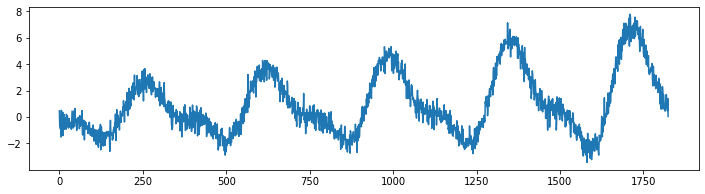

In [9]:
from sklearn.dummy import DummyRegressor
from sklego.meta import GroupedEstimator, DecayEstimator
from sklego.datasets import make_simpleseries

yt = make_simpleseries(seed=1)
df = (pd.DataFrame({"yt": yt,
                   "date": pd.date_range("2000-01-01", periods=len(yt))})
      .assign(m=lambda d: d.date.dt.month)
      .reset_index())

plt.figure(figsize=(12, 3))
plt.plot(make_simpleseries(seed=1));

We will create two models on this dataset. One model calculates the average
value per month in our timeseries and the other does the same thing but will
decay the importance of making accurate predictions for the far history.


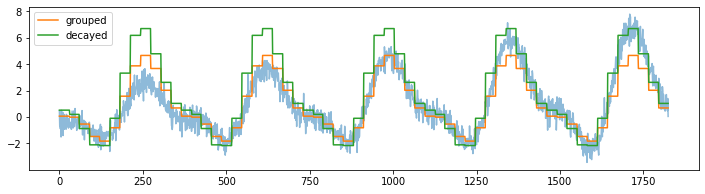

In [10]:
mod1 = (GroupedEstimator(DummyRegressor(), groups=["m"])
        .fit(df[['m']], df['yt']))


mod2 = (GroupedEstimator(DecayEstimator(DummyRegressor(), decay=0.9), groups=["m"])
        .fit(df[['index', 'm']], df['yt']))

plt.figure(figsize=(12, 3))
plt.plot(df['yt'], alpha=0.5);
plt.plot(mod1.predict(df[['m']]), label="grouped")
plt.plot(mod2.predict(df[['index', 'm']]), label="decayed")
plt.legend()

The decay parameter has a lot of influence on the effect of the model but one
can clearly see that we shift focus to the more recent data.
